In [1]:
cd /Users/lisa2021/Desktop/mqmtest_final/

/Users/lisa2021/Desktop/mqmtest_final


In [2]:
result_path = 'basic_prompt/result/basic_prompt_gpt4o.csv'

from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from util.evaluation import extract_json, handle_no_error_segment, get_segment_score, extract_json_llama,f1
from util.evaluation import extract_output_error_list,get_recall, get_precision,extract_json,get_severity_and_type_from_recall,get_severity_and_type_from_precision
from util.analysis import mqm_scoring, gold_list_omission
from util.comet_data import calculate_quality_score
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
import numpy as np
import ast
import pandas as pd
import json
from openai import OpenAI
dev_df = pd.read_csv('data/prompt_dev/prompt_dev.csv', index_col=0)
pd.set_option('display.max_colwidth', None)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# system_prompt = "You are a professional Chinese-English translator."
# instruction_prompt = """
# Your task is to identify translation errors from the pair of source Chinese sentence and the target English sentence.

# Please identify up to 5 errors and assign an error type for each with a severity label from 'major' and 'minor', using the MQM annotation scheme.
# Please provide the output only in json format:

# [{"error type": (value scope: accuracy, style, fluency, terminology, locale convention, other),
# "error span index": (split the target sentence using NLTK tokenizer and get the marked text start and end index),
# "marked text":(the identified error in the target sentence),
# "severity": (major or minor)
# "explanation":}, {},{}]"""


# def call_gpt_zero_shot(system_prompt,instruction_prompt,cn,en,model = "gpt-3.5-turbo-0125", seed = 240425, max_tokens = 512,temperature = 1, top_p = 1,frequency_penalty =0, presence_penalty= 0):
#     client = OpenAI()
#     response = client.chat.completions.create(
#     model= model,
#     seed = seed,
#     max_tokens=max_tokens,
#     temperature = temperature,
#     top_p= top_p,
#     frequency_penalty = frequency_penalty,
#     presence_penalty = presence_penalty,
#     messages=[
#         {"role": "system", "content": system_prompt},
#         {"role": "user", "content": instruction_prompt},
#         {"role": "assistant","content": "Ok, I am ready. Please provide me with a Chinese source sentence and its English target translation."},
#         {"role": "user", "content": f"Source: {cn}; Target: {en}"}
#     ])
#     result = response.choices[0].message.content
#     fingerprint = response.system_fingerprint

#     #print('response.model_dump_json():')
#     #print(json.dumps(json.loads(response.model_dump_json()), indent=4))

#     return result, fingerprint

# def calling(x,y):

#     result, fingerprint = call_gpt_zero_shot(system_prompt,instruction_prompt,x,y,model = 'gpt-4o' ,seed = 240425, max_tokens = 1024,temperature = 1, top_p = 1,frequency_penalty =0, presence_penalty= 0)
#     return result,fingerprint

# gpt_40_output_fingerprint = dev_df.apply(lambda row: calling(row['source'], row['target']), axis = 1, result_type='expand')
# result_40 = pd.concat([dev_df, gpt_40_output_fingerprint], axis = 1)
# result_40.rename(columns={0:'gpt 4.0 output', 1:'fingerprint'},inplace=True)
# result_40.to_csv(result_path)

# Analysis

In [4]:
# column transformation
pd.set_option('display.max_colwidth', None)
df = pd.read_csv(result_path, index_col='Unnamed: 0')
df['parse_gold_error_list'] = df['parse_gold_error_list'].apply(lambda x: ast.literal_eval(x))

df['f_json_extract'] = df['gpt 4.0 output'].apply(extract_json)
df = df[df['f_json_extract'].notna()]
# filter out invalid json

df['2_parse_output_error_list'] = df.apply(lambda x: extract_output_error_list(x['f_json_extract'], x['target'], x['source']), axis = 1)
df = df[df['2_parse_output_error_list'].notna()]
df['3_system_error_num'] = df['2_parse_output_error_list'].apply(lambda x: len(x))
print(df['3_system_error_num'].value_counts())
df['f_gold_no_error_segment'] = df.apply(lambda x: handle_no_error_segment(x['gold_error_num'], x['3_system_error_num']), axis = 1)



df['4_recall'] = df.apply(lambda x: get_recall(x['parse_gold_error_list'], x['2_parse_output_error_list'], x['f_gold_no_error_segment']), axis= 1)
df['5_precision'] = df.apply(lambda x: get_precision(x['parse_gold_error_list'], x['2_parse_output_error_list'], x['f_gold_no_error_segment']), axis= 1)


display_columnls = ['source', 'target', 'joined omission', 'gpt 4.0 output','gold_error_num', 'fingerprint', 'parse_gold_error_list',
        '2_parse_output_error_list', '3_system_error_num', 'gold_mqm_score',
        '4_recall', '5_precision','quality_score']
df = df[display_columnls]

df['segment_recall'] = df['4_recall'].apply(get_segment_score)
df['segment_precision'] = df['5_precision'].apply(get_segment_score)

df['f1'] = df.apply(lambda x: f1(x['segment_recall'],x['segment_precision']),axis = 1)
df['6_gpt_4.0_mqm_score'] = df['2_parse_output_error_list'].apply(mqm_scoring)
df['system_mqm_Minus_gold_mqm'] = df.apply(lambda x: x['6_gpt_4.0_mqm_score'] - x['gold_mqm_score'], axis = 1)
df['system_quality_score'] = df.apply(lambda x: calculate_quality_score(x['2_parse_output_error_list'],x['target']),axis = 1)
print(len(df))

3_system_error_num
5    288
3    205
2    172
4    161
1    103
0     28
Name: count, dtype: int64
957


# System level

## Error sum, error length

Gold error sum:  1525
System error sum:  3146
5


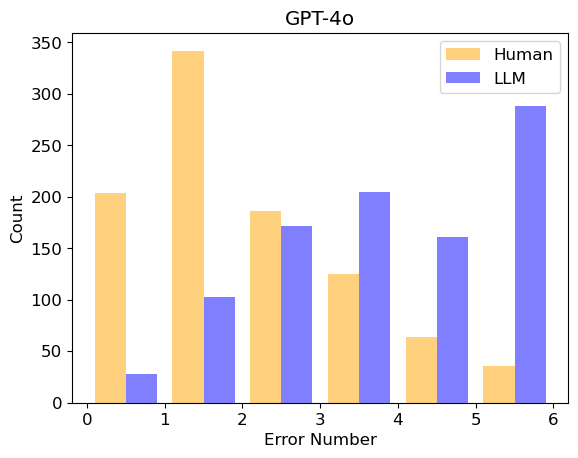

In [5]:
from util.plotting import hist_plot
# system sum
import matplotlib.pyplot as plt
print('Gold error sum: ', df['gold_error_num'].sum())
plt.rcParams.update({'font.size': 12})
print('System error sum: ', df['3_system_error_num'].sum())
hist_plot(df['gold_error_num'], df['3_system_error_num'] , 'GPT-4o')

In [6]:
tokens_g = []
annotation_length_gold = []
mqm_n_g = 0
for mqms in df['parse_gold_error_list']:
    for mqm in mqms:
        mqm_n_g += 1
        mqm_t = word_tokenize(mqm[2])
        annotation_length_gold.append(len(mqm_t))
        tokens_g.extend(mqm_t)
characters_g = sum([len(token) for token in tokens_g])
print('characters in total: ', characters_g / mqm_n_g)
print('tokens in total: ',len(tokens_g))
print('errors in total: ', mqm_n_g)
print('GOLD: token in total / error in total:', len(tokens_g) / mqm_n_g)

# calculating character average for each error span and token average
# how many tokens per annotation?
from nltk.tokenize import word_tokenize
tokens_s = []
annotation_length_system = [] # for length plotting
mqm_n_s = 0
for mqms in df['2_parse_output_error_list']:
    for mqm in mqms:
        mqm_n_s += 1
        mqm_t = word_tokenize(mqm[2])
        annotation_length_system.append(len(mqm_t))
        tokens_s.extend(mqm_t)
characters_s = sum([len(token) for token in tokens_s])
print('characters in total: ', characters_s / mqm_n_s)
print('tokens in total: ',len(tokens_s))
print('errors in total: ', mqm_n_s)
print('SYSTEM: token in total / error in total:', len(tokens_s) / mqm_n_s)

characters in total:  17.80983606557377
tokens in total:  5891
errors in total:  1525
GOLD: token in total / error in total: 3.862950819672131
characters in total:  13.523839796567069
tokens in total:  9022
errors in total:  3146
SYSTEM: token in total / error in total: 2.8677685950413223


## Severity, Error type

In [7]:
system_severity = {}
system_severity['major'] = 0
system_severity['minor'] = 0

gold_severity = {}
gold_severity['Major'] = 0
gold_severity['Minor'] = 0

for g in df['parse_gold_error_list']:
    for gg in g:
        if gg[1] == 'Major':
            gold_severity['Major'] += 1
        if gg[1] == 'Minor':
            gold_severity['Minor'] +=1

for s in df['2_parse_output_error_list']:
    for ss in s:
        if ss[1] == 'major':
            system_severity['major'] += 1
        if ss[1] == 'minor':
            system_severity['minor'] +=1


from collections import Counter

gold_error_type = []
system_error_type = []


for g in df['parse_gold_error_list']:
    for gg in g:
        if gg[0].lower() == 'omission':
            gold_error_type.append('Accuracy')
        else:
            gold_error_type.append(gg[0])


for s in df['2_parse_output_error_list']:
    for ss in s:
        system_error_type.append(ss[0])
print(gold_severity)
print(system_severity)
print(len(gold_error_type),Counter(gold_error_type))
print(len(system_error_type),Counter(system_error_type))

{'Major': 322, 'Minor': 1203}
{'major': 1256, 'minor': 1890}
1525 Counter({'Style': 553, 'Accuracy': 548, 'Fluency': 377, 'Terminology': 33, 'Locale Convention': 14})
3146 Counter({'accuracy': 1224, 'fluency': 1027, 'style': 467, 'terminology': 324, 'locale convention': 78, 'punctuation': 13, 'termology': 2, 'other': 2, 'consistency': 2, 'location convention': 2, 'redundancy': 1, 'translation': 1, 'translation accuracy': 1, 'clarity': 1, 'term': 1})


## MQM correlation

In [8]:
pearson = df['gold_mqm_score'].corr(df['6_gpt_4.0_mqm_score'], method = 'pearson')
print(pearson)
spearman = df['gold_mqm_score'].corr(df['6_gpt_4.0_mqm_score'], method = 'spearman')
print(spearman)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.4060343689840794
0.3941711693817504
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
3146 / 957
1525 / 957

1.593521421107628

# Recall

In [10]:
df_recall = df[df['4_recall'].apply(lambda x: isinstance(x, list))]
severity_error_type_r = df_recall.apply(lambda x: get_severity_and_type_from_recall(x['parse_gold_error_list'], x['2_parse_output_error_list']), axis = 1, result_type='expand')

df_recall = pd.concat([df_recall, severity_error_type_r], axis = 1)
df_recall.rename(columns = {0:'error_type', 1:'severity'},inplace= True)

gold_error_type_r = []
system_error_type_r = []
for x in df_recall['error_type']:
    for xx in x:
        gold_error_type_r.append(xx[0].lower())
        system_error_type_r.append(xx[1])

gold_severity_r = []
system_severity_r = []
for x in df_recall['severity']:
    for xx in x:
        gold_severity_r.append(xx[0].lower())
        system_severity_r.append(xx[1])

all_recalls = []
for recall_list in df_recall['4_recall']:
    all_recalls.extend(recall_list)
r = sum(all_recalls) / len(all_recalls)
print(r)

0.5670539689326892


                             GPT-4o
                   precision    recall  f1-score   support

         accuracy       0.45      0.59      0.51       369
            style       0.54      0.15      0.24       395
          fluency       0.23      0.37      0.29       175
      terminology       0.08      0.35      0.13        20
locale convention       0.25      0.08      0.12        12

        micro avg       0.36      0.36      0.36       971
        macro avg       0.31      0.31      0.26       971
     weighted avg       0.44      0.36      0.35       971

[[219  30  95  23   2]
 [171  60 114  46   1]
 [ 75  22  65  12   0]
 [ 11   0   2   7   0]
 [  8   0   1   2   1]]


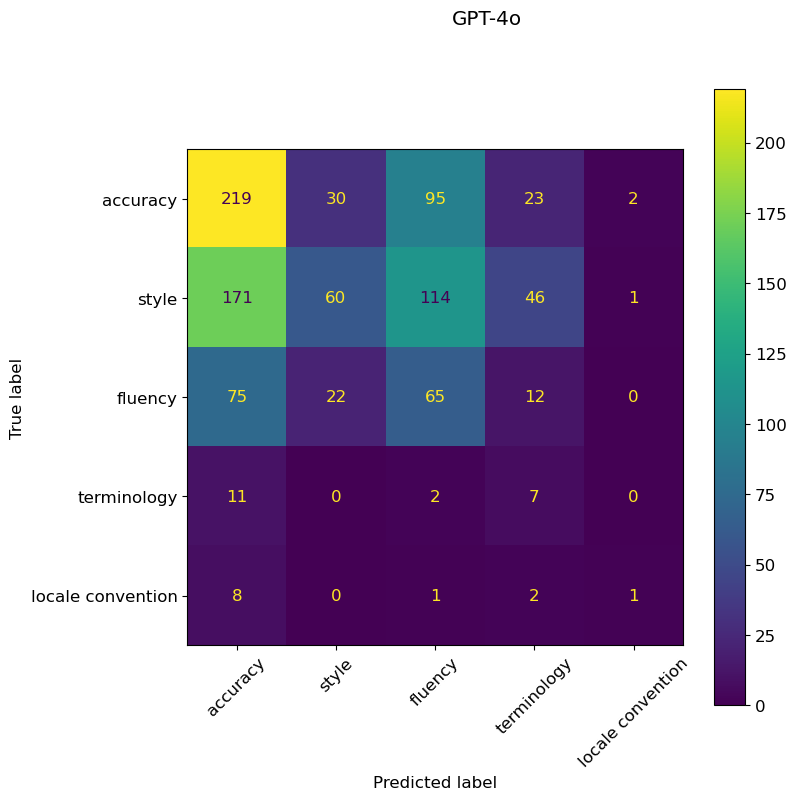

In [11]:
import matplotlib.pyplot as plt
labels = ['accuracy', 'style', 'fluency', 'terminology', 'locale convention',]
print('                             GPT-4o')
print(classification_report(gold_error_type_r, system_error_type_r,labels=labels))

cm = confusion_matrix(gold_error_type_r, system_error_type_r,labels = labels )
print(cm)

disp = ConfusionMatrixDisplay.from_predictions(gold_error_type_r,system_error_type_r,labels=labels)
#(confusion_matrix=cm, display_labels= labels)


fig = disp.figure_
fig.set_figwidth(8)
fig.set_figheight(8)
fig.set_label('test')
plt.xticks(rotation=45)

fig.suptitle('GPT-4o')
plt.rcParams.update({'font.size': 16})

In [12]:
75 + 22 + 65 + 12

174

[[182  65]
 [401 323]]
              precision    recall  f1-score   support

       major       0.31      0.74      0.44       247
       minor       0.83      0.45      0.58       724

    accuracy                           0.52       971
   macro avg       0.57      0.59      0.51       971
weighted avg       0.70      0.52      0.54       971



Text(0.5, 0.98, 'GPT-4o')

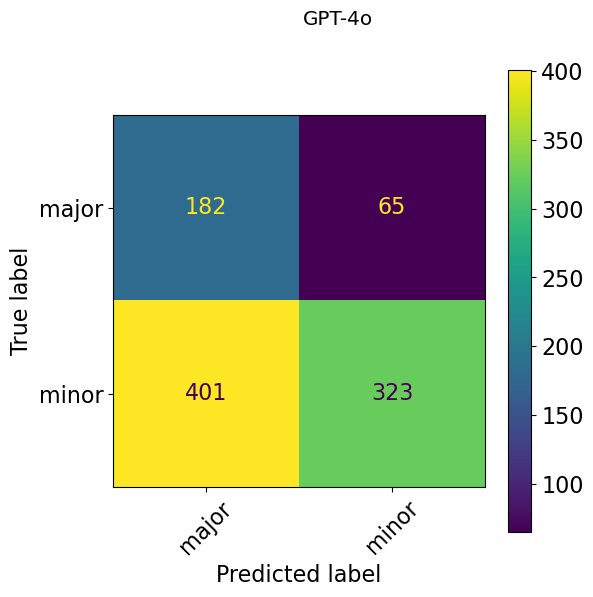

In [13]:
labels = ['major','minor']
cm = confusion_matrix(gold_severity_r, system_severity_r,labels = labels )
print(cm)
print(classification_report(gold_severity_r, system_severity_r,labels=labels))
disp = ConfusionMatrixDisplay.from_predictions(gold_severity_r,system_severity_r,labels=labels)
fig = disp.figure_
fig.set_figwidth(6)
fig.set_figheight(6)
fig.set_label('test')
plt.xticks(rotation=45)
plt.rcParams.update({'font.size': 12})
fig.suptitle('GPT-4o')

# Precision

In [14]:
df_precision = df[df['5_precision'].apply(lambda x: isinstance(x, list))]
severity_error_type_p = df_precision.apply(lambda x: get_severity_and_type_from_precision(x['parse_gold_error_list'], x['2_parse_output_error_list']), axis = 1, result_type='expand')

df_precision = pd.concat([df_precision, severity_error_type_p], axis = 1)
df_precision.rename(columns = {0:'error_type', 1:'severity'},inplace= True)

gold_error_type_p = []
system_error_type_p = []
for x in df_precision['error_type']:
    for xx in x:
        gold_error_type_p.append(xx[1].lower())
        system_error_type_p.append(xx[0])

gold_severity_p = []
system_severity_p = []
for x in df_precision['severity']:
    for xx in x:
        gold_severity_p.append(xx[1].lower())
        system_severity_p.append(xx[0])

all_precisions = []
for pre_list in df_precision['5_precision']:
    all_precisions.extend(pre_list)
p = sum(all_precisions) / len(all_precisions)
print(p)

0.4779171614106341


In [15]:
# labels = ['accuracy', 'fluency','style','terminology','locale convention']

# print(classification_report(gold_error_type_p, system_error_type_p,labels=labels))
# cm = confusion_matrix(gold_error_type_p, system_error_type_p,labels = labels )
# print(cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)
# disp.plot()

In [16]:
all_precisions = []
for pre_list in df_precision['5_precision']:
    all_precisions.extend(pre_list)
p = sum(all_precisions) / len(all_precisions)
print(p)

0.4779171614106341


# Overall analysis

In [17]:
print("Total segment", len(df))
print('Gold error sum: ', df['gold_error_num'].sum())
print('System error sum: ', df['3_system_error_num'].sum())
print(gold_severity)
print(system_severity)
print(len(gold_error_type),Counter(gold_error_type))
print(len(system_error_type),Counter(system_error_type))


print('Total segments:', len(df))
print()
#recall, precision
#print('Total overlap:', len(df_recall))
#total_overlap = len(df_recall)
# print('r:',round(r,3))
# print('p:',round(p,3))

#Recall
r = df['segment_recall'].mean()
p = df['segment_precision'].mean()
f1 = df['f1'].mean()
print("Total recall", round(r,3))
print("Total precision", round(p,3))
print("Total F1", round(f1,3))

print()

pearson_qs = df['quality_score'].corr(df['system_quality_score'], method = 'pearson')
spearman_qs = df['quality_score'].corr(df['system_quality_score'], method = 'spearman')
print('Pearson:', round(pearson_qs,3))
print('Spearman:', round(spearman_qs,3))

Total segment 957
Gold error sum:  1525
System error sum:  3146
{'Major': 322, 'Minor': 1203}
{'major': 1256, 'minor': 1890}
1525 Counter({'Style': 553, 'Accuracy': 548, 'Fluency': 377, 'Terminology': 33, 'Locale Convention': 14})
3146 Counter({'accuracy': 1224, 'fluency': 1027, 'style': 467, 'terminology': 324, 'locale convention': 78, 'punctuation': 13, 'termology': 2, 'other': 2, 'consistency': 2, 'location convention': 2, 'redundancy': 1, 'translation': 1, 'translation accuracy': 1, 'clarity': 1, 'term': 1})
Total segments: 957

Total recall 0.422
Total precision 0.351
Total F1 0.318

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kern

In [18]:
df['fingerprint'].value_counts()

fingerprint
fp_319be4768e    945
fp_aa87380ac5     12
Name: count, dtype: int64

In [19]:
#df1[df1['2_parse_output_error_list'].isna() == True][['original_index','f_json_extract']]

# More analysis

In [20]:
# what errors does llm miss
#df[df['segment_recall'] == 0]

# It is possible for GPT 4o to miss errors in gold annotations in three different situations:
# \begin{itemize}
#     \item Segments have gold errors but GPT 4o didn't predict any error.
#     \item Segments have gold errors and GPT 4o predicted errors, but none overlapped.
#     \item Segments have gold errors and some are overlapped with GPT 4o output and some aren't.
# \end{itemize}
miss_error_1 = []
for ind,r in df[df['4_recall'] == 'no overlap span'].iterrows():
    for ee in r['parse_gold_error_list']:
        miss = ee[0]  + ee[1] # + ee[2]
        miss_error_1.append(miss)

miss_error_2 = []
for ind,r in df[df['4_recall'] == 'gold not system 0'].iterrows():
    for ee in r['parse_gold_error_list']:
        miss = ee[0]  + ee[1] #+ ee[2]
        miss_error_2.append(miss)

miss_error_3 = []
for ind, r in df[df['4_recall'].apply(lambda x: isinstance(x, list))].iterrows():
    for r_ind, rv in enumerate(r['4_recall']):
        if rv == 0:
            miss = r['parse_gold_error_list'][r_ind][0]  + r['parse_gold_error_list'][r_ind][1] # + ' '+  r['parse_gold_error_list'][r_ind][2]
            miss_error_3.append(miss)

Counter(miss_error_1 + miss_error_2 + miss_error_3)
#len(miss_error_1 + miss_error_2 + miss_error_3)


Counter({'FluencyMinor': 202,
         'StyleMinor': 156,
         'AccuracyMinor': 74,
         'OmissionMajor': 49,
         'OmissionMinor': 38,
         'AccuracyMajor': 18,
         'TerminologyMinor': 7,
         'TerminologyMajor': 6,
         'StyleMajor': 2,
         'Locale ConventionMinor': 2})

In [21]:
extra_error_1 = []
for ind,r in df[df['5_precision'] == 'no overlap span'].iterrows():
    for ee in r['2_parse_output_error_list']:
        extra = ee[0] + ee[1] #+'_'+ ee[2]
        extra_error_1.append(extra)

extra_error_2 = []
for ind,r in df[df['5_precision'] == 'gold not system 0'].iterrows():
    for ee in r['2_parse_output_error_list']:
        extra = ee[0] + ee[1] #+ '_'+ ee[2]
        extra_error_2.append(extra)

extra_error_3 = []
for ind, r in df[df['5_precision'].apply(lambda x: isinstance(x, list))].iterrows():
    for r_ind, rv in enumerate(r['5_precision']):
        if rv == 0:
            extra = r['2_parse_output_error_list'][r_ind][0] + r['2_parse_output_error_list'][r_ind][1] #+ '_'+ r['2_parse_output_error_list'][r_ind][2]
            extra_error_3.append(extra)

Counter(extra_error_1 + extra_error_2 + extra_error_3)

Counter({'fluencyminor': 437,
         'accuracymajor': 327,
         'styleminor': 213,
         'terminologyminor': 123,
         'accuracyminor': 117,
         'locale conventionminor': 42,
         'fluencymajor': 31,
         'terminologymajor': 21,
         'punctuationminor': 6,
         'stylemajor': 3,
         'otherminor': 2,
         'locale conventionmajor': 2,
         'consistencyminor': 2,
         'punctuationmajor': 1,
         'termmajor': 1,
         'redundancyminor': 1,
         'termologyminor': 1,
         'translationmajor': 1,
         'translation accuracymajor': 1,
         'clarityminor': 1,
         'location conventionminor': 1})

In [22]:
print(327 + 31 + 21 + 3 + 2 + 1 + 1 + 1 + 1)
len(extra_error_1 + extra_error_2 + extra_error_3)
1334 - 388

388


946

In [23]:
def generate_few_shot(source, target, mqmlist):
   # pair =f'''{"role": "user","content": "Source:{source}; Target:{target}"}'''
    pair = f'''{{"role": "user", "content": "Source: {source}; Target: {target}"}},'''
    mqm = []
    for e in mqmlist:
        e_dict = {}
        e_dict['error type'] = e[0]
        e_dict['severity'] = e[1]
        e_dict['marked text'] = e[2]
        e_dict['error span index'] = e[3]
        mqm.append(e_dict)


    example_json = pair + '{"role": "assistant", "content":' + str(mqm) + '}'
    example_json = example_json.replace("'",'"')
    return example_json


for ind, r in df.head(1000).iterrows():
    if len(r['parse_gold_error_list']) == 2:
        for e in r['parse_gold_error_list']:
            if e[0] == 'Omission':# and e[1] == 'Major':
                print(r[['source','target','parse_gold_error_list']])
                print(generate_few_shot(r['source'],r['target'],r['parse_gold_error_list']))
                print()

source                                                                                                     7，实际上，我非常在意商家做出的承诺。
target                                                        In fact, I care very much about the promises made by businesses.
parse_gold_error_list    [[Style, Minor, businesses, {'start': 12, 'end': 12}], [Omission, Minor, 7，, {'start': 3, 'end': 4}]]
Name: 17, dtype: object
{"role": "user", "content": "Source: 7，实际上，我非常在意商家做出的承诺。; Target: In fact, I care very much about the promises made by businesses."},{"role": "assistant", "content":[{"error type": "Style", "severity": "Minor", "marked text": "businesses", "error span index": {"start": 12, "end": 12}}, {"error type": "Omission", "severity": "Minor", "marked text": "7，", "error span index": {"start": 3, "end": 4}}]}

source                                                                                                       用了很久，除了低音出不来，总体还不错。
target                                              I tried to 

In [24]:
df.columns

Index(['source', 'target', 'joined omission', 'gpt 4.0 output',
       'gold_error_num', 'fingerprint', 'parse_gold_error_list',
       '2_parse_output_error_list', '3_system_error_num', 'gold_mqm_score',
       '4_recall', '5_precision', 'quality_score', 'segment_recall',
       'segment_precision', 'f1', '6_gpt_4.0_mqm_score',
       'system_mqm_Minus_gold_mqm', 'system_quality_score'],
      dtype='object')

# Error analysis

In [25]:
for ind, r in df.head(100).sort_values(by = 'system_mqm_Minus_gold_mqm', ascending=False).iterrows():
    if len(r['parse_gold_error_list']) == 0 and len(r['2_parse_output_error_list']) != 0 :
        print('Segment ind:', ind)
        print(r[['source','target']])
        for iind, e in enumerate(r['2_parse_output_error_list']):
            print('Error ' + str(iind))
            print(e)
        print('system_mqm_Minus_gold_mqm:',r['system_mqm_Minus_gold_mqm'])
        print()

Segment ind: 50
source                                  8 部分字符和代码的说明
target    8 Description of some characters and codes
Name: 50, dtype: object
Error 0
['accuracy', 'major', 'Description of', {'start': 1, 'end': 2}, "The target sentence should specify 'parts' to accurately represent '部分' in the source sentence."]
Error 1
['accuracy', 'major', 'some', {'start': 3, 'end': 3}, "'部分' should be translated as 'parts' rather than 'some' to maintain accuracy."]
Error 2
['fluency', 'major', '8', {'start': 0, 'end': 0}, "The sentence could be more fluent by placing '8' at the end of the translation, after 'parts'."]
system_mqm_Minus_gold_mqm: 15

Segment ind: 32
source                                                                                                                                                                                                                                                                                                                                           